# Plot the climatological mean

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask import delayed
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(4)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Client: 'tcp://146.118.38.52:40425' processes=0 threads=0, memory=0 B>

In [3]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from glob import glob
from datetime import datetime
from scipy import signal
from soda.dataio.suntans.sunxray import Sunxray
#from soda.dataio.suntans.sunpy import Spatial
from soda.utils.othertime import SecondsSince
from soda.dataio.suntans.suntans_ugrid import ugrid
from soda.utils.myproj import MyProj
from soda.utils.mynumpy import grad_z

from soda.utils.otherplot import axcolorbar
from soda.utils.maptools import plotmap

from matplotlib import rcParams
import os

from netCDF4 import Dataset

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [4]:
infile = '../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'

sun = Sunxray(infile)
P = MyProj('merc')
# Convert the suntans coordinates to lat/lon
sun.xp, sun.yp = P.to_ll(sun.xp, sun.yp)
sun.xv, sun.yv = P.to_ll(sun.xv, sun.yv)
sun._xy = None # reset this

/home/mrayson/code/soda/soda/dataio/suntans/sunxray.py:53: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  mask_and_scale=True, decode_times=True)
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [5]:
def quivergrid(sun, u, v, dx, xlims, ylims, **kwargs):
    """
    Create a quiverplot on a regular grid
    """
    # Create the grid
    x0, x1 = xlims[0], xlims[1]
    y0, y1 = ylims[0], ylims[1]
    X,Y = np.meshgrid( np.arange(x0, x1, dx),\
        np.arange(y0,y1, dx))

    # Interpolate
    ug = sun.interpolate(u, X, Y)
    vg = sun.interpolate(v, X, Y)

    qq = plt.quiver(X, Y, ug, vg, **kwargs)

    return qq



In [12]:

#cmap = cmocean.cm.amp
cmap = 'RdBu'

# Depth plotting
#basedir = r'/home/suntans/Share/ScottReef/DATA'
basedir = r'/group/pawsey0106/mrayson/DATA'
bathyfile = r'%s/BATHYMETRY/ETOPO1/ETOPO1_Bed.nc'%basedir
#bathylevs= [-1000.,-100.]
bathylevs= [100.,1000.]

#figfile = '../../FIGURES/TimorSea_SUNTANS_TideComparison'

xlims = [110,132.5]
ylims = [-23.0,-7.5]

clevs = np.arange(-0.5,0.55,0.05)

ss = 6 # subsample interval for vectors
scalefac = 17.5
dxvec = 0.4 #  degrees

klayer = [0]

dx = 0.025

coastfile = r'%s/COAST/GSHHS_shp/i/GSHHS_i_L1.shp'%basedir

#######

# open the bathy
dsz = xr.open_dataset(bathyfile)

# Bathymetry plotting function
def plot_bathy():
    #plot_skill()
    #xlims = [da.lon.min(),da.lon.max()]
    #ylims = [da.lat.min(),da.lat.max()]
    z = dsz.topo.sel(lon=slice(xlims[0],xlims[1]), lat=slice(ylims[1],ylims[0]))
    plt.contour(z.lon.values, z.lat.values, z.values,\
        bathylevs,
        linewidths=0.3,
        linestyles='-', colors='k')

#da = xray.open_dataset(ncfile)

#xlims = [da.lon.min(),da.lon.max()]
#xlims = [112., 135.]
#ylims = [da.lat.min(),da.lat.max()]
#X, Y = np.meshgrid(da.lon.values, da.lat.values)
x = np.arange(xlims[0],xlims[1],dx)
y = np.arange(ylims[0],ylims[1],dx)
X,Y = np.meshgrid(x,y)

# # Load the suntans object
# sun = Spatial(ncfile, projstr='merc', klayer=klayer)

# # Convert the suntans coordinates to lat/lon
# sun.xp, sun.yp = sun.to_latlon(sun.xp, sun.yp)
# sun.xv, sun.yv = sun.to_latlon(sun.xv, sun.yv)
# sun.xy = sun.cellxy(sun.xp, sun.yp)



In [16]:
def plot_suntans_mean_uv(sun, u, v, ssh, timestr):
    #     # Compute the mean
    #     sun.tstep = sun.getTstep(tstart, tend)
    #     print 'tstep ', sun.tstep[0], sun.tstep[-1]

    #     print 'Loading temp...'
    #     temp = sun.loadData(variable='temp').mean(axis=0)
    #     print 'Loading uc...'
    #     u = sun.loadData(variable='uc').mean(axis=0)
    #     print 'Loading vc...'
    #     v = sun.loadData(variable='vc').mean(axis=0)

    ######
    # Plot it up
    ######

    ### SUNTANS data
    #ax = plt.subplot(211)

    #sun.plot(z=temp, xlims=xlims, ylims=ylims, cmap=cmap)
    #plt.colorbar(sun.patches)
    cf = sun.contourf(ssh, clevs=clevs, xlims=xlims, ylims=ylims,\
            colorbar=False, cmap=cmap,\
            )

    qq = quivergrid(sun, u, v, dxvec, xlims,ylims,\
            scale=scalefac,\
            #scale_units='xy',\
            color='k')

    plt.quiverkey(qq, 129., -22., 0.5, '0.5 [m/s]', zorder=1e6, coordinates='data')

    #plt.quiverkey(qq, 0.8, 0.1, Escale, r'[%3.1f kW m$^{-1}$]'%(Escale*1e-3))

    plotmap(coastfile, fieldname=None)

    # Plot the bathymetry
    cf2 = sun.contourf(sun._ds.dv, clevs=bathylevs,\
            xlims=xlims, ylims=ylims,\
            colorbar=False, filled=False, \
            colors='k', linewidths=0.5,\
        )


    #plt.text(0.7,0.1,'(a) SUNTANS $\eta_{%s}$'%con, transform=ax.transAxes)

    plt.title('')

    cb=axcolorbar(cf[2], pos=[0.30,0.25,0.44,0.04])
    cb.ax.set_title('SSH [m] - {}'.format(timestr))
    cb.set_ticks([clevs[0],0,clevs[-1]])



In [17]:

def plot_month(timestep, timestr):
    ssh = sun._ds.eta.sel(time=timestep, method='nearest').values
    uc = sun._ds.uc.sel(time=timestep, method='nearest').values[0,:]
    vc = sun._ds.vc.sel(time=timestep, method='nearest').values[0,:]

    plot_suntans_mean_uv(sun, uc, vc, ssh, timestr)
    
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plot_month('2013-10-15 00:00:00', 'Oct 2013')
ax.set_xlabel('Longitude [$^{\circ}$E]')
ax.set_ylabel('Latitude [$^{\circ}$N]')
#ax.xlabel('Longitude [$^{\circ}$E]')
plt.text(0.05,1.01,'(a)',transform=ax.transAxes)

ax = plt.subplot(122)
plot_month('2014-02-15 00:00:00', 'Feb 2014')
ax.set_xlabel('Longitude [$^{\circ}$E]')
ax.set_yticklabels([])
plt.text(0.05,1.01,'(b)',transform=ax.transAxes)

plt.tight_layout()

plt.savefig('../FIGURES/suntans_mean_uv_ssh.png', dpi=150)
plt.savefig('../FIGURES/suntans_mean_uv_ssh.pdf', dpi=150)

/home/mrayson/code/soda/soda/utils/otherplot.py:448: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # You call fig.tight_layout BEFORE creating the colorbar
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/home/mrayson/code/soda/soda/utils/otherplot.py:448: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # You call fig.tight_layout BEFORE creating the colorbar
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


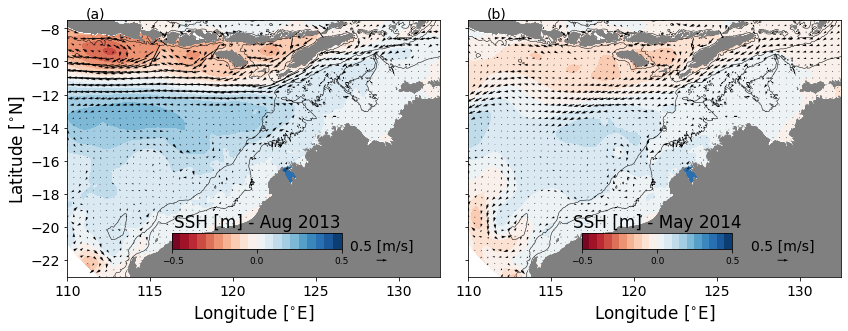

In [19]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plot_month('2013-08-15 00:00:00', 'Aug 2013')
ax.set_xlabel('Longitude [$^{\circ}$E]')
ax.set_ylabel('Latitude [$^{\circ}$N]')
#ax.xlabel('Longitude [$^{\circ}$E]')
plt.text(0.05,1.01,'(a)',transform=ax.transAxes)

ax = plt.subplot(122)
plot_month('2014-05-15 00:00:00', 'May 2014')
ax.set_xlabel('Longitude [$^{\circ}$E]')
ax.set_yticklabels([])
plt.text(0.05,1.01,'(b)',transform=ax.transAxes)

plt.tight_layout()


In [ ]:
# Compute the thermocline depth (taken as the first moment of the density stratification)

def calc_tcline_props(timestep):
    rho = sun._ds.rho.sel(time=timestep, method='nearest')
    dz= sun._ds.dz.values
    z_w = np.cumsum(np.hstack([0,dz]))
    Z = 0.5*(z_w[1:]+z_w[0:-1])

    N2 = -9.81/2014*np.gradient(rho.values, -dz,axis=0)
    N2[np.isnan(N2)] = 0.

    # tcline = np.sum(N2*Z[:,None]**2*dz[:,None],axis=0) / np.sum(N2*Z[:,None]*dz[:,None],axis=0)
    N2max = np.max(N2,axis=0)

    idx = np.zeros((sun.Nc,), dtype=np.int)
    for ii in range(sun.Nc):
        idx[ii] = np.argwhere(N2[:,ii] == N2max[ii])[0,0]

    zmax = Z[idx]

    return N2max, zmax


In [204]:
def plot_suntans_mean_tcline(sun, zmax, clevs, timestr):

    #sun.plot(z=temp, xlims=xlims, ylims=ylims, cmap=cmap)
    #plt.colorbar(sun.patches)
    cf = sun.contourf(zmax, clevs=clevs, xlims=xlims, ylims=ylims,\
            colorbar=False,\
            )

    plotmap(coastfile, fieldname=None)

    # Plot the bathymetry
    cf2 = sun.contourf(sun._ds.dv, clevs=bathylevs,\
            xlims=xlims, ylims=ylims,\
            colorbar=False, filled=False, \
            colors='k', linewidths=0.5,\
        )



    plt.title('')

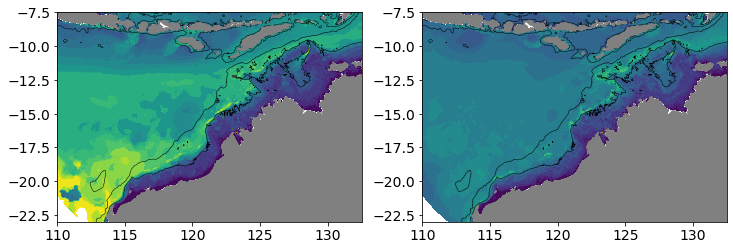

In [207]:

plt.figure(figsize=(12,6))

ax=plt.subplot(121)
N2max, zmax = calc_tcline_props('2013-09-15 00:00:00')
cf =  plot_suntans_mean_tcline(sun, zmax, np.arange(0,210,10), 'Sep 2013' )

ax.set_ylabel('Latitude [$^{\circ}$N]')
ax.set_xlabel('Longitude [$^{\circ}$E]')
plt.text(0.05,1.01,'(c)',transform=ax.transAxes)

ax=plt.subplot(122)
N2max, zmax = calc_tcline_props('2014-04-15 00:00:00')
cf =  plot_suntans_mean_tcline(sun, zmax, np.arange(0,210,10), 'Jan 2014' )
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^{\circ}$E]')
plt.text(0.05,1.01,'(d)',transform=ax.transAxes)

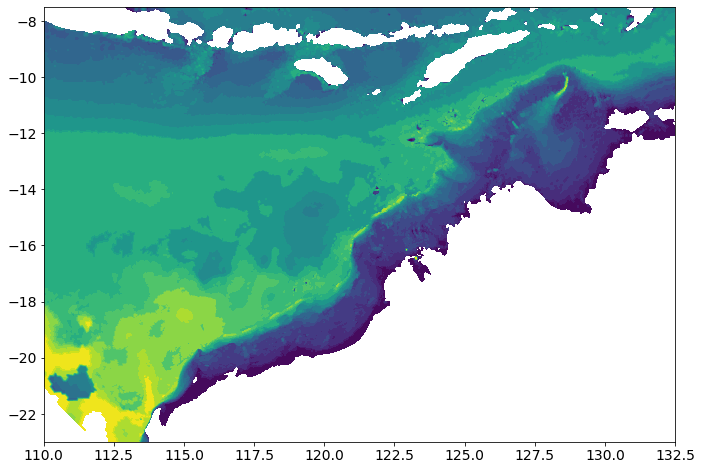

In [179]:
plt.figure(figsize=(12,8))
sun.plotcelldata(tcline,vmin=0,vmax=400)

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2ac706423490>)

In [195]:
plt.figure(figsize=(12,8))
#sun.plotcelldata(N2max,vmin=0,vmax=1e-2)
cf = sun.contourf(N2max, clevs=np.arange(0,0.01,0.0005), xlims=xlims, ylims=ylims,\
            colorbar=False, filled=False, \
            )